<div style="width: 100%; overflow: hidden;">
    <a href="http://www.uc.pt/fctuc/dei/">
    <div style="display: block;margin-left: auto;margin-right: auto; width: 50%;"><img src="https://eden.dei.uc.pt/~naml/images_ecos/dei25.png"  /></div>
    </a>
</div>

# FIAD | 2024| Project 2

### Introduction

The primary goal of this project is to gain practical experience from the concepts lectured during the theoretical classes. For this, we built a Naive Bayes classifier for an health related classification problem.


Given some features regarding patients health and other personal data, our model will classify if a patient should stay at hospital or if he can go Home. These features are:

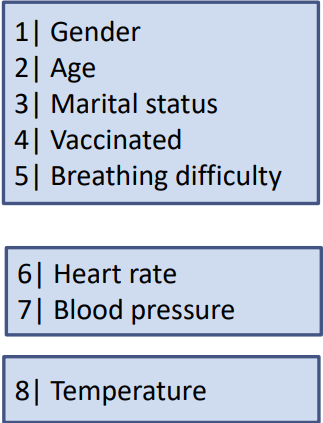

We will also use a condition to help the decision of the model. This condition is based on knowledge and it states that if a patient's breathing difficulty is above moderate and its temperature is above 37.8 then it should stay at the Hospital.


For the technical part we will be exploring implementing this classification model using libraries like sklearn to implement the Naive Bayes, exploring the results with different variants of the classifier.

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


## Loading Data and Pre-processing

In [38]:
df = pd.read_csv('Meta2COVID.txt', sep="   ", header=None, engine='python')
df.columns = ["gender", "age", "marital_status", "vaccinated", "breathing_difficulty", "heart_rate", "blood_pressure", "temperature", "Target"]

# CATEGORICAL VARIABLES
categorical_columns = ['gender', 'marital_status', 'vaccinated', 'breathing_difficulty', 'Target']

# CONVERT TO INT
for column in categorical_columns:
    df[column] = pd.factorize(df[column])[0]


df.head()

,gender,age,marital_status,vaccinated,breathing_difficulty,heart_rate,blood_pressure,temperature,Target
0,0,71.0,0,0,0,83.456271,135.09198,37.503016,0
1,0,82.0,0,1,1,79.449753,132.81408,36.832310,1
2,1,65.0,1,1,1,85.470779,137.33184,37.580005,1
3,1,64.0,1,1,0,51.561135,149.29652,36.959370,0
4,0,85.0,0,1,2,89.008377,121.42689,37.744883,1


## Exploratory Data Analysis

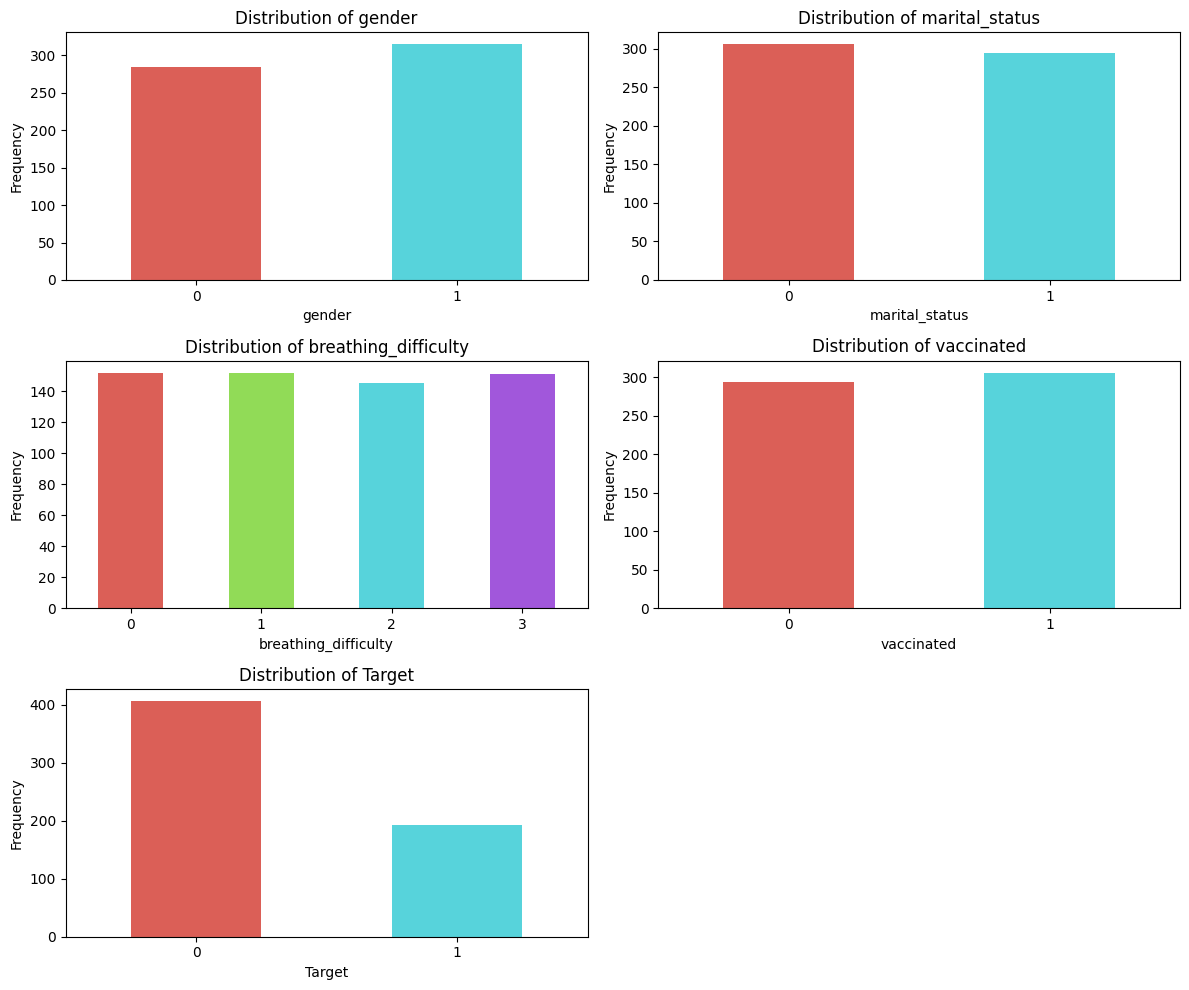

In [39]:
fig, axes = plt.subplots(3, 2, figsize=(12, 10))
axes = axes.flatten()

# Define the color palette
palette = sns.color_palette("BrBG")

for idx, col in enumerate(['gender', 'marital_status', 'breathing_difficulty', 'vaccinated', 'Target']):
    palette = sns.color_palette("hls", df[col].nunique())
    df[col].value_counts().sort_index().plot(kind='bar', ax=axes[idx], color=palette)
    axes[idx].set_title(f'Distribution of {col}')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Frequency')
    axes[idx].set_xticks(range(df[col].nunique()))
    axes[idx].set_xticklabels(df[col].sort_values().unique(), rotation=0)

fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

As we can see, the categorical variables are all reasonably balanced with exception of the target variable. The target variable is the decision if a patient should go home (0) or stay at the hospital (1). Clearly there are a lot more patients who go home and only around a third of the patients stay at the hospital.

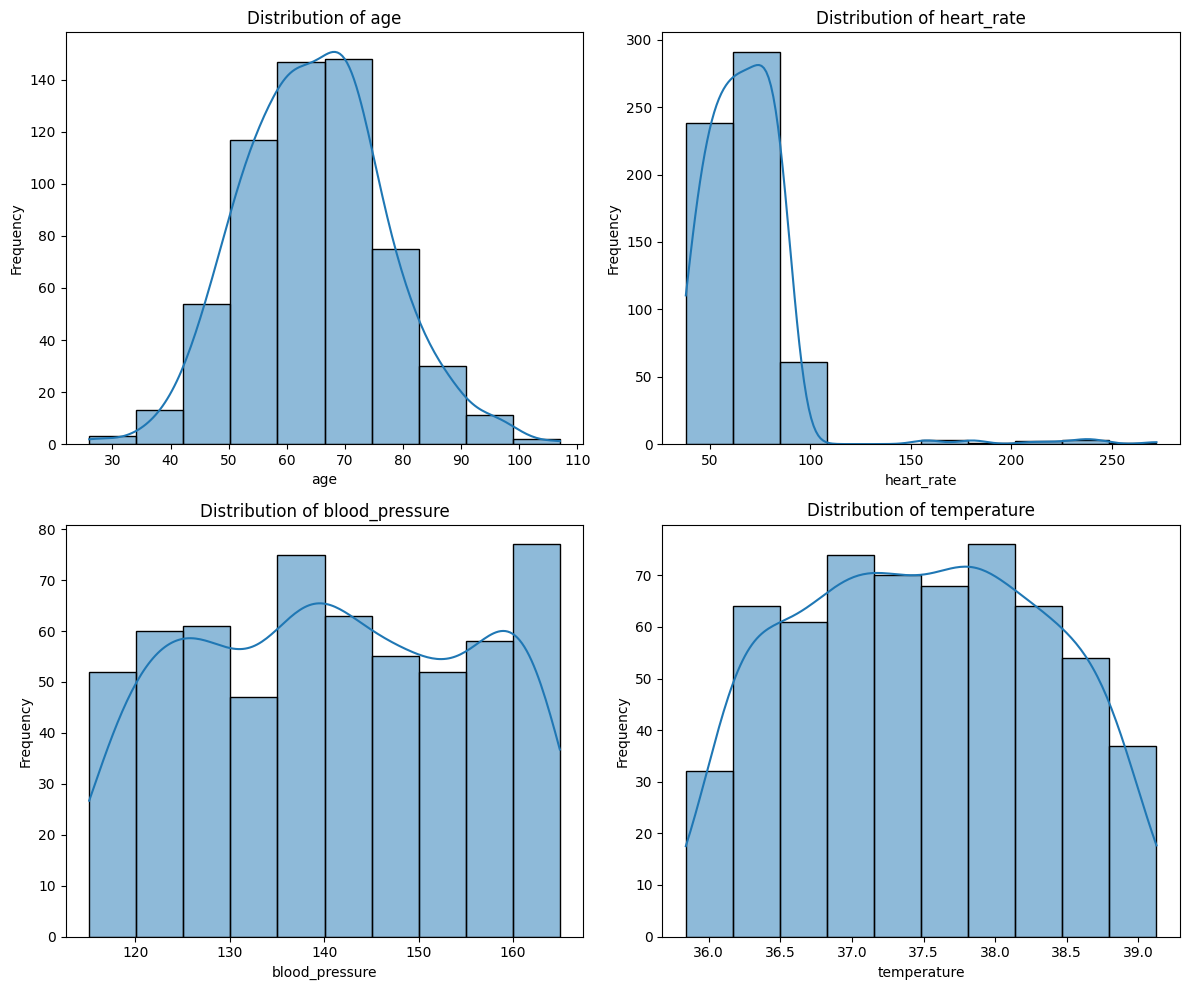

In [40]:
# Plotting the distribution of each numerical variable
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for idx, col in enumerate(['age', 'heart_rate', 'blood_pressure', 'temperature']):
    sns.histplot(df[col], bins=10, kde=True, ax=axes[idx])
    axes[idx].set_title(f'Distribution of {col}')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

Now, we will check the assumptions of the Gaussian Naive Bayes, by ensuring the continuous features follow a normal distribution.

Visually, we can already see some kurtosis and skewneess, which maybe implicate that the variables need further processing. 

To be sure, we will perform a Kolmogorov-Smirnov statistical to validate our assumption.

In [41]:
import scipy.stats as stats

# Kolmogorov-Smirnov Test
for col in ['age', 'heart_rate', 'blood_pressure', 'temperature']:
    standardized_data = (df[col] - df[col].mean()) / df[col].std()
    stat, p = stats.kstest(standardized_data, 'norm')
    if p <= 0.05:
        print(f'{col} is not Normally Distributed')
    else:
        print(f'{col} is  Normally Distributed')


age is  Normally Distributed
heart_rate is not Normally Distributed
blood_pressure is not Normally Distributed
temperature is  Normally Distributed


Since the heart_rate and blood_pressure variables aren't normally distributed we will discretize this variables using k-bins. This technique divides continuous data into k equal width bins, transforming continuous variables into numerical ones. Binning these continuous features into discrete categories allows to estimate probabilities more flexibly, making the classifier less sensible to extreme values and less restrictive on the normality assumption.


In [42]:
def discretize(dataset, col, nBins):
    '''
    Split continuous variables
    into bins
    '''
    bins = np.linspace(
        start=dataset[col].min(),
        stop=dataset[col].max(),
        num=nBins+1
    ).tolist()
    return pd.cut(x=dataset[col], bins=bins, labels=False, include_lowest=True)

In [43]:
# age_bins = 10
heart_rate_bins = 8
blood_press_bins = 7
# temperature_bins = 5

# df['age'] = discretize(df,'age',age_bins)
df['heart_rate'] = discretize(df,'heart_rate',heart_rate_bins)
df['blood_pressure'] = discretize(df,'blood_pressure',blood_press_bins)
# df['temperature'] = discretize(df,'temperature',temperature_bins)
df.head()

,gender,age,marital_status,vaccinated,breathing_difficulty,heart_rate,blood_pressure,temperature,Target
0,0,71.0,0,0,0,1,2,37.503016,0
1,0,82.0,0,1,1,1,2,36.832310,1
2,1,65.0,1,1,1,1,3,37.580005,1
3,1,64.0,1,1,0,0,4,36.959370,0
4,0,85.0,0,1,2,1,0,37.744883,1


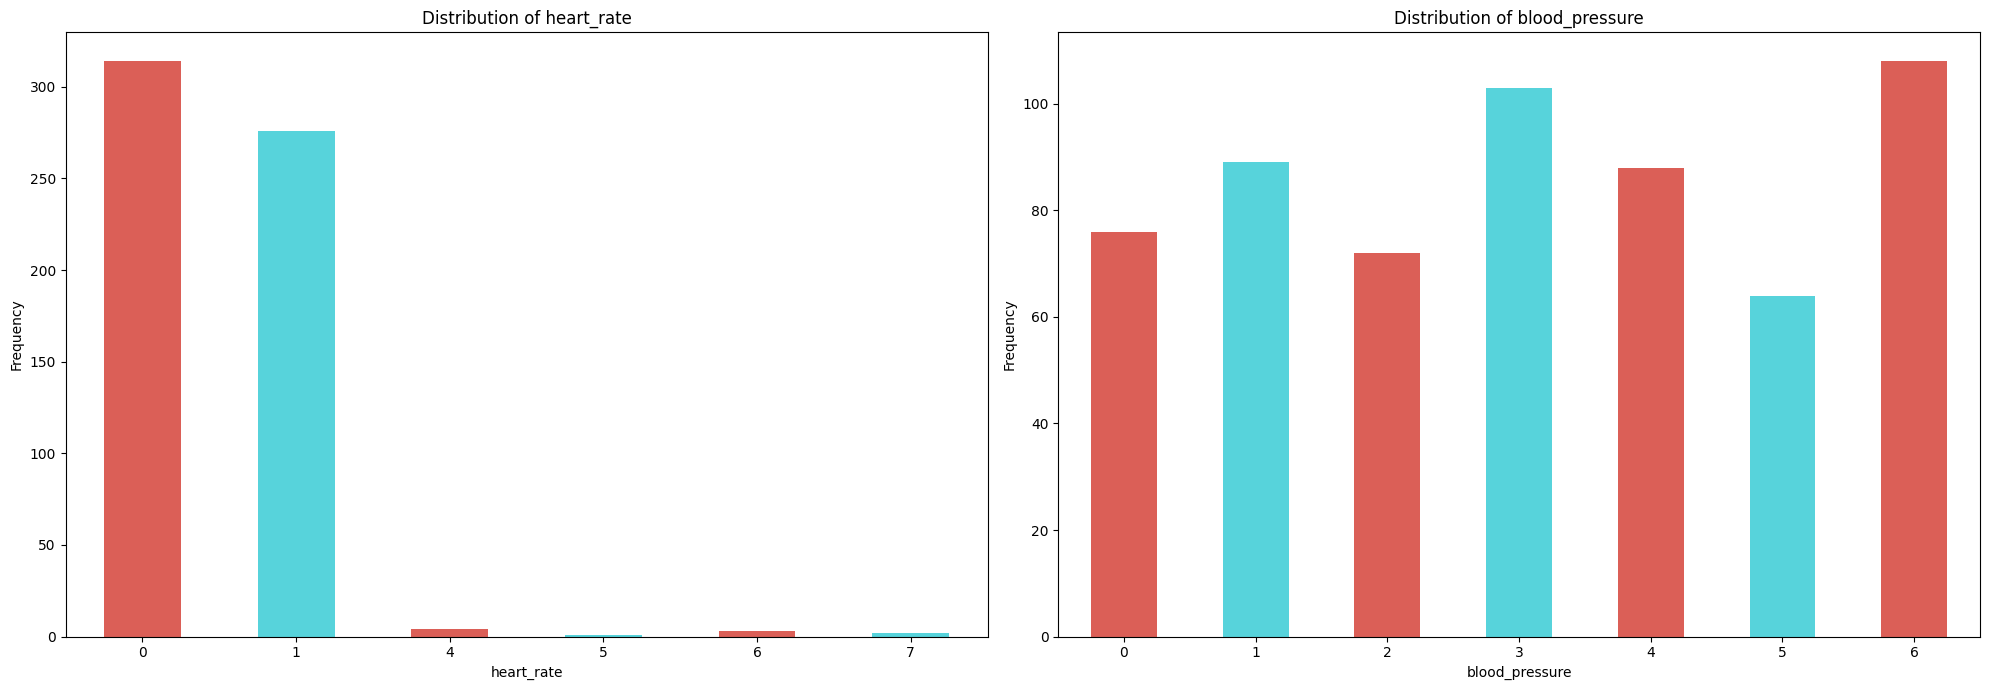

In [44]:
fig, axes = plt.subplots(1, 2, figsize=(20, 7))
axes = axes.flatten()

for idx, col in enumerate(['heart_rate', 'blood_pressure']):
    df[col].value_counts().sort_index().plot(kind='bar', ax=axes[idx], color=palette)
    axes[idx].set_title(f'Distribution of {col}')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Frequency')
    axes[idx].set_xticks(range(df[col].nunique()))
    axes[idx].set_xticklabels(df[col].sort_values().unique(), rotation=0)

plt.tight_layout()
plt.show()

### Mutual Information 

We are calculating mutual information to identify and define redundant features in our dataset. By quantifying the amount of shared information between features, mutual information helps us determine which features contribute most to our classifier. 

In [ ]:
from sklearn.feature_selection import mutual_info_classif
X = df[['gender', 'marital_status', 'breathing_difficulty', 'age', 'vaccinated','heart_rate', 'blood_pressure', 'temperature']]
y = df['Target']
mi_scores = mutual_info_classif(X, y, discrete_features=True)
mi_scores_df = pd.DataFrame(mi_scores, index=X.columns, columns=['Mutual Information Score'])
mi_scores_df = mi_scores_df.sort_values(by='Mutual Information Score', ascending=False)

In [46]:
mi_scores_df

,Mutual Information Score
temperature,0.628119
vaccinated,0.082840
age,0.057797
gender,0.037254
breathing_difficulty,0.026144
heart_rate,0.015786
blood_pressure,0.004996
marital_status,0.002337


We can clearly see that marital status has the lowest mutual information scores. Additionally, marital status does not appear to be relevant to the health problem we are addressing. Therefore, we will drop this feature.

Similarly, we will also drop the blood pressure feature, as it has a low mutual information score and does not seem relevant to the health problem we are dealing with.

In [47]:
df = df.drop(['marital_status', 'blood_pressure'], axis=1)
df.head()


,gender,age,vaccinated,breathing_difficulty,heart_rate,temperature,Target
0,0,71.0,0,0,1,37.503016,0
1,0,82.0,1,1,1,36.832310,1
2,1,65.0,1,1,1,37.580005,1
3,1,64.0,1,0,0,36.959370,0
4,0,85.0,1,2,1,37.744883,1


## Gaussian NB

We firstly will start by performing the modeling using the sklearn GaussianNB. 

In [110]:
categorical_columns = ['gender', 'vaccinated', 'breathing_difficulty']
numerical_columns = ['age', 'heart_rate', 'temperature']
target_column = 'Target'

In [111]:
X = df[categorical_columns + numerical_columns]
y = df[target_column]

In [112]:
model = GaussianNB()

In [113]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [114]:
model.fit(X_train,y_train)

GaussianNB()

In [115]:
y_pred = model.predict(X_test)
y_pred

array([0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1])

W-Accuracy: 0.8083
W-Precision: 0.8261
W-Recall: 0.5000
W-F1 Score: 0.6230


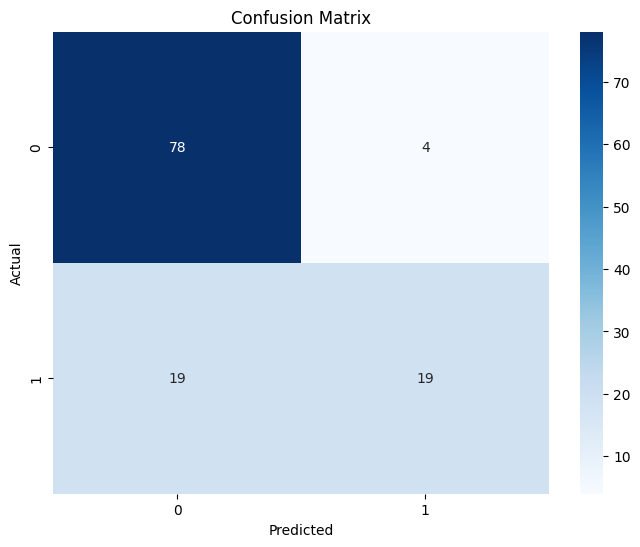

In [116]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Display the metrics
print(f'W-Accuracy: {accuracy:.4f}')
print(f'W-Precision: {precision:.4f}')
print(f'W-Recall: {recall:.4f}')
print(f'W-F1 Score: {f1:.4f}')

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


The most important metric in our problem is recall, not accuracy, because our primary concern is ensuring that patients who need to stay at the hospital are not mistakenly classified as being safe to go home. Currently, our model's recall is at 50%, which indicates that half of the patients who should remain in the hospital are correctly identified, while the other half are not. Improving recall is crucial for patient safety.

## Gaussian NB + Knowledge

Now let's implement the same model but add the knowledge condition and benchmark the results

In [84]:
from sklearn.base import BaseEstimator, ClassifierMixin

class CustomClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, base_model=None):
        self.base_model = base_model if base_model else GaussianNB()
    
    def fit(self, X, y):
        self.base_model.fit(X, y)
        return self
    
    def predict(self, X):
        # Apply the custom condition
        custom_predictions = np.where(
            (X['breathing_difficulty'] == 3) & (X['temperature'] > 37.8),
            1,  # If condition is met, predict 1
            self.base_model.predict(X)  # Else, use the base model's prediction
        )
        return custom_predictions

In [85]:
X = df[categorical_columns + numerical_columns]
y = df[target_column]

# Split data into training and testing sets 80-20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=41)

# Initialize and train the custom classifier
custom_clf = CustomClassifier(base_model=GaussianNB())
custom_clf.fit(X_train, y_train)

CustomClassifier(base_model=GaussianNB())

In [86]:
y_pred = custom_clf.predict(X_test)

W-Accuracy: 0.7167
W-Precision: 0.6154
W-Recall: 0.5581
W-F1 Score: 0.5854


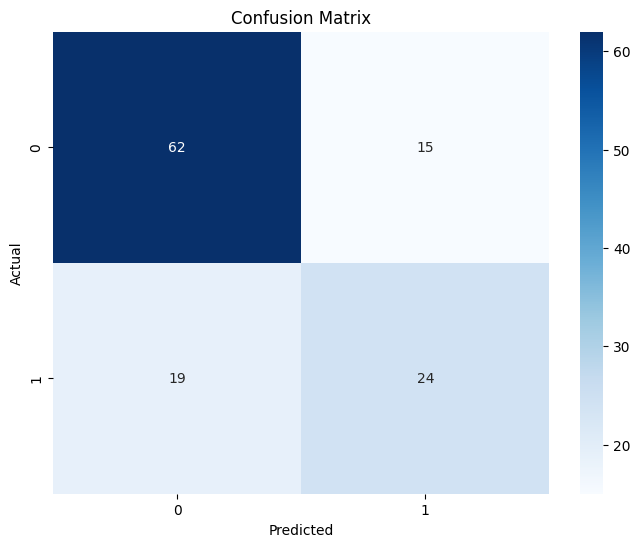

In [87]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Display the metrics
print(f'W-Accuracy: {accuracy:.4f}')
print(f'W-Precision: {precision:.4f}')
print(f'W-Recall: {recall:.4f}')
print(f'W-F1 Score: {f1:.4f}')

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

We can see that the recall actually got better, even though the other metrics got worse. This improvement in recall is crucial, as it means our model is now better at correctly identifying patients who need to remain in the hospital, enhancing patient safety.

### MultinomialNB

Now, we will experiment with a Multinomial Naive Bayes classifier. We want to explore if using a classifier without being bound to a gaussian assumption for the features distribution would improve the performance.

In [89]:
from sklearn.base import BaseEstimator, ClassifierMixin

class CustomClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, base_model=None):
        self.base_model = base_model if base_model else MultinomialNB()
    
    def fit(self, X, y):
        self.base_model.fit(X, y)
        return self
    
    def predict(self, X):
        # Apply the custom condition
        custom_predictions = np.where(
            (X['breathing_difficulty'] == 3) & (X['temperature'] > 37.8),
            1,  # If condition is met, predict 1
            self.base_model.predict(X)  # Else, use the base model's prediction
        )
        return custom_predictions

In [90]:
X = df[categorical_columns + numerical_columns]
y = df[target_column]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)

# Initialize and train the custom classifier
custom_clf = CustomClassifier(base_model=MultinomialNB())
custom_clf.fit(X_train, y_train)

CustomClassifier(base_model=MultinomialNB())

In [91]:
y_pred = custom_clf.predict(X_test)


W-Accuracy: 0.6833
W-Precision: 0.4118
W-Recall: 0.2000
W-F1 Score: 0.2692


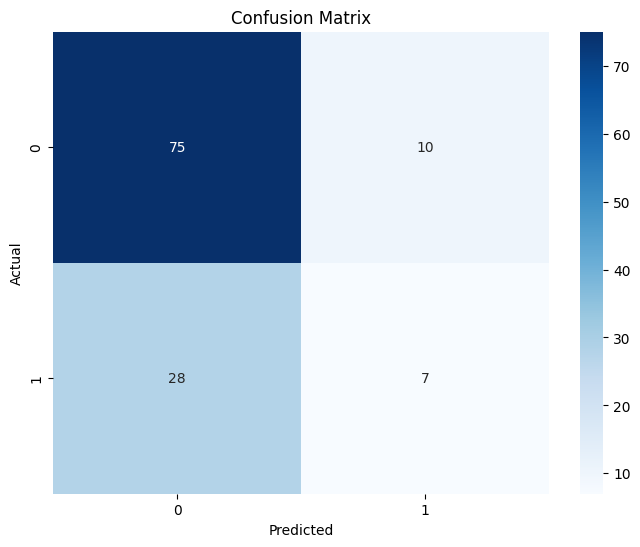

In [93]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Display the metrics
print(f'W-Accuracy: {accuracy:.4f}')
print(f'W-Precision: {precision:.4f}')
print(f'W-Recall: {recall:.4f}')
print(f'W-F1 Score: {f1:.4f}')

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Clearly the Multinomial NB got worse results.

Gaussian NB is simpler compared to multinomial NB in terms of assumptions and model complexity. In some cases, a simpler model might generalize better with less overfitting, especially if the data is not large enough to support the additional complexity of multinomial NB.

### Naive Bayes from scratch

Now let's implement a version of NB without libraries with the code and instructions provided on the practical class.

In [103]:
df

,gender,age,vaccinated,breathing_difficulty,heart_rate,temperature,Target
0,0,71.0,0,0,1,37.503016,0
1,0,82.0,1,1,1,36.832310,1
2,1,65.0,1,1,1,37.580005,1
3,1,64.0,1,0,0,36.959370,0
4,0,85.0,1,2,1,37.744883,1
...,...,...,...,...,...,...,...
595,1,60.0,1,0,1,36.099066,0
596,0,56.0,1,0,1,38.274403,1
597,0,55.0,0,1,0,38.173531,0
598,1,60.0,1,2,0,37.818543,1


In [104]:
def prior(y):
    class_types = np.unique(y)
    prior = {}
    size = len(y)
    for i in range(len(class_types)):
        prior[i] = len(y[y == class_types[i]]) / size
        
    return prior

In [105]:
def categorical_likelihoods(data, class_labels):
    likelihoods = []
    for feature_idx in range(data.shape[1] - 1):
        feature_likelihoods = {}
        for class_label in class_labels:
            feature_likelihoods[class_label] = {}
            subset = data[data[:, -1] == class_label][:, feature_idx]
            unique_values, value_counts = np.unique(subset, return_counts=True)
            for idx, value in enumerate(unique_values):
                feature_likelihoods[class_label][value] = value_counts[idx] / len(subset)
        likelihoods.append(feature_likelihoods)
    return likelihoods

def continuous_likelihoods(data, class_labels):
    likelihoods = []
    for feature_idx in range(data.shape[1] - 1):
        feature_likelihoods = {}
        for class_label in class_labels:
            feature_likelihoods[class_label] = {}
            subset = data[data[:, -1] == class_label][:, feature_idx]
            mean, std = norm.fit(subset)
            feature_likelihoods[class_label]['mean'] = mean
            feature_likelihoods[class_label]['std'] = std
        likelihoods.append(feature_likelihoods)
    return likelihoods

In [106]:
def bayes(likelihood_continuous, likelihood_discrete, prior_probabilities, continuous_values, discrete_values):
    class_probabilities = []
    
    for i in range(len(prior_probabilities)):
        class_prob = prior_probabilities[i]
        
        # Calculate product of Gaussian likelihoods for continuous features
        for j in range(len(continuous_values)):
            mean = likelihood_continuous[j][i]['mean']
            std = likelihood_continuous[j][i]['std']
            class_prob *= norm.pdf(continuous_values[j], loc=mean, scale=std)
        
        # Calculate product of categorical likelihoods for discrete features
        for j in range(len(discrete_values)):
            value = discrete_values[j]
            if value in likelihood_discrete[j][i]:
                class_prob *= likelihood_discrete[j][i][value]
            else:
                class_prob *= 1e-6  # Small value for unknown discrete values
        
        class_probabilities.append(class_prob)
    
    total_probability = np.sum(class_probabilities)
    normalized_probabilities = np.asarray(class_probabilities) / total_probability
    predicted_class = np.argmax(class_probabilities)
    
    return normalized_probabilities, predicted_class, class_probabilities

In [107]:
X_discrete = df[['gender','vaccinated','breathing_difficulty','heart_rate','Target']]
X_continuous = df[['age','temperature','Target']]


split = int(0.8 * len(df))

X_train_discrete = X_discrete[:split]
X_test_discrete = X_discrete[split:]
X_train_continuous = X_continuous[:split]
X_test_continuous = X_continuous[split:]

# Convert the DataFrames to numpy arrays
X_train_discrete = np.array(X_train_discrete)
X_test_discrete = np.array(X_test_discrete)
X_train_continuous = np.array(X_train_continuous)
X_test_continuous = np.array(X_test_continuous)

#Calculate the likelihoods for categorical features and continuous
likelihood_discrete = categorical_likelihoods(X_train_discrete,X_train_discrete[:,-1])
likelihood_continuous = continuous_likelihoods(X_train_continuous,X_train_continuous[:,-1])

#Calculate prior
prior_use = prior(df[['Target']].values)
y_true = df[['Target']]
y_true[split:]
y_pred = []

In [108]:
total = len(X_test_continuous)
for i in range(total):
    _,predicted_class, _ = bayes(likelihood_continuous, likelihood_discrete, prior_use, X_test_continuous[i][:-1], X_test_discrete[i][:-1])
    
    #Implement knowledge condition
    if X_test_continuous[i][-2] >=37.8 and X_test_discrete[i][2]==3:
        predicted_class = 1
    y_pred.append(predicted_class)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Display the metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Confusion Matrix:\n{conf_matrix}')

Accuracy: 0.8250
Precision: 0.6944
Recall: 0.7143
F1 Score: 0.7042
Confusion Matrix:
[[74 11]
 [10 25]]


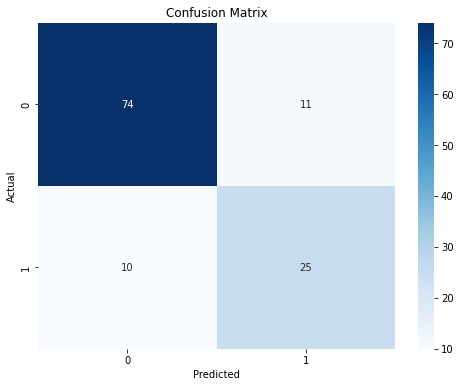

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

This implementation works best for our problem. By calculating all the likelihoods, prior and probabilities by scratch we were able to get the best performance.

# Results and Conclusion

In conclusion, our experiments revealed that the Multinomial Naive Bayes (NB) classifier demonstrated the poorest performance, with a Weighted Recall of 0.5000 and a Weighted F1 Score of 0.6230. This outcome suggests that the model's underlying assumptions were not well-suited to our dataset, despite our efforts to explore models with fewer restrictive assumptions and to avoid the normality assumptions typically associated with Gaussian distributions.

In contrast, the Gaussian Naive Bayes (GaussianNB) model from scikit-learn exhibited improved performance, achieving a Weighted Recall of 0.5581 and a Weighted F1 Score of 0.5854. This indicates that, for our data, the GaussianNB's assumptions about feature distribution were more appropriate, resulting in better performance.

The most interesting results, however, was achieved by the custom model we implemented from scratch, which attained a Weighted Recall of 0.7143 and a Weighted F1 Score of 0.7042. Using the code provided from the practical classes, surpassed the score from off-the-shelf solution with the GuassianNB.

Throughout our analysis, we prioritized the recall score, recognizing its critical importance in medical decision-making contexts. Our primary concern was ensuring that patients requiring hospitalization were not mistakenly classified as being safe to go home, which could have severe implications for patient health and safety.

Additionally, our feature analysis revealed that marital status and blood pressure had low mutual information scores, indicating they were not relevant to the health outcomes we were predicting. As a result, we decided to exclude these features from our models.

For future work, exploring data augmentation techniques such as generative AI to oversample our data could enhance performance. Additionally, experimenting with more complex models like Gradient Boosting or Neural Networks could provide valuable insights and comparisons to simpler, easier to implement, and more interpretable models like the ones we did.